## 1. Import and Install Dependencies

In [ ]:
%pip install --user tensorflow==2.6.0 tensorflow-gpu==2.6.0 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from keras_self_attention import SeqSelfAttention

## 2. Keypoints using Mediapipe Holistic

In [2]:
mp_holistic = mp.solutions.holistic #Holistic model 整体模型mp
mp_drawing = mp.solutions.drawing_utils # Drawing utilities 绘图工具

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR Conversion BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                  # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR Conversion RGB 2  BGR
    return image, results

def draw_styled_landmarks(image, results):
    
     # 轮廓线 Draw face connection
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             #mp_drawing.DrawingSpec(color=(80,110,10), thickness = 1, circle_radius = 1),
                             #mp_drawing.DrawingSpec(color=(80,256,121), thickness = 1, circle_radius = 1))
    
     # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness = 2, circle_radius = 4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness = 2, circle_radius = 2)) 
    
    # draw left hand connections,
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness = 2, circle_radius = 4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness = 2, circle_radius = 2))
    
    # draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness = 2, circle_radius = 4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness = 2, circle_radius = 2))

def extract_keypoints(results):
    #如果frame中没有左手关键点就会抛出错误 注意左右手没有 res.visibility参数
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)# 压平 33 * 4
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])

## 4. Setup folders for collection

In [85]:
# Path for exported data, numpy arrays 制作关键点数据集文件夹
DATA_PATH = os.path.join('data/train') 
wlasl = ['book', 'drink', 'computer', 'before', 'chair', 'go', 'clothes', 'who', 'candy', 'cousin','deaf', 'fine', 'help', 'no', 'thin', 'walk', 'year', 'yes', 'all', 'black', 'cool', 'finish', 'hot', 'like', 'many', 'mother', 'now', 'orange', 'table', 'thanksgiving', 'what', 'woman', 'bed', 'blue', 'bowling', 'can', 'dog', 'white', 'wrong', 'accident', 'apple', 'bird', 'change', 'color', 'corn', 'cow', 'dance', 'dark', 'doctor']
# Actions that we try to detect 只需要在这里加action即可 参考路径 data\WLASL_train下的文件名
actions = np.array(sorted(wlasl[0:10]))

# Thirty videos worth of data
#no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 30
print(len(sorted(wlasl[0:20])))

20


In [ ]:
# 获取视频数据集中每条视频帧的数量，i.e.,no_fps 并保存到 fps_list
for action in actions:
    fps_list = []
    for root, dirs, files in os.walk(r"rawdata\train\{}".format(action)):  # 这里就填文件夹目录就可以了
        for file in files:
            # 获取文件路径
            if ('.mp4' in file):
                path = os.path.join(root, file)
                video = cv2.VideoCapture(path)
                no_fps = video.get(7)
                # video_fps = int(video.get(cv2.CAP_PROP_FPS))
                fps_list.append(no_fps)
        print(action, "'s # of videos: ", len(files)) # 把这个数 可以作为no_sequences 视频数量 ！！注意必须与此Cell中#2 for 循环一起组合使用，否则len（files）数量不正确。原因是得不到正确的遍历，值只为最后一个动作的文件数总和
        print("The frames that each video contains: ", fps_list,'\n')

## Preprocess Data and Create Labels and Features

In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical 
import tensorflow as tf

In [86]:
def label_data(base_data_path, actions, sequence_length):
    label_map = {label: num for num, label in enumerate(actions)}
    sequences, labels = [], []
    for action in actions:
        source_folder = os.path.join(base_data_path, action)
        leng = len(os.listdir(source_folder))
        for sequence in range(leng):
            window = []
            for frame_num in range(sequence_length):
                frame_path = os.path.join(source_folder, str(sequence), "{}.npy".format(frame_num))
                res = np.load(frame_path)
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    print(label_map)
    return sequences, labels

In [87]:
train_data_path = "data/train"
val_data_path = "data/val"

In [88]:
train_sequences, train_labels = label_data(train_data_path, actions, sequence_length)
val_sequences, val_labels = label_data(val_data_path, actions, sequence_length)

{'before': 0, 'book': 1, 'candy': 2, 'chair': 3, 'clothes': 4, 'computer': 5, 'cousin': 6, 'drink': 7, 'go': 8, 'who': 9}
{'before': 0, 'book': 1, 'candy': 2, 'chair': 3, 'clothes': 4, 'computer': 5, 'cousin': 6, 'drink': 7, 'go': 8, 'who': 9}


In [89]:
# Apply to_categorical(labels).astype(int) on labels
train_labels_categorical = to_categorical(train_labels).astype(int)
val_labels_categorical = to_categorical(val_labels).astype(int)

In [90]:
X_train, y_train = np.array(train_sequences),train_labels_categorical
X_val, y_val = np.array(val_sequences), val_labels_categorical

## 7. Build and Train

In [52]:
from tensorflow.python.keras.models import Model # allow us to build a sequential neural network
from tensorflow.python.keras.layers import LSTM, Dense, Input # LSTM: temoporal component, Dense: a normal fully connected layer
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint # allow us to perform some logging inside, trace and monitor our model as its training
import datetime

In [91]:
now = datetime.datetime.now()
log_dir = os.path.join('Logs', now.strftime("%Y-%m-%d-%H-%M"))
tb_callback = TensorBoard(log_dir=log_dir)
print(now.strftime("%Y-%m-%d-%H-%M"))

2023-04-10-12-08


In [108]:
# Define the model
def create_model(input_shape, num_heads):
    inputs = Input(shape=input_shape)
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=input_shape[1]
    )(inputs, inputs, inputs)
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(attention)
    dense = Dense(64, activation="relu")(avg_pool)
    outputs = Dense(len(actions), activation="softmax")(dense)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [93]:
del model

In [ ]:
input_shape = (sequence_length, train_sequences[0][0].shape[0])
num_heads = 8
# Create the model
model = create_model(input_shape, num_heads)

In [110]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [96]:
# Set up the ModelCheckpoint callback
checkpoint_filepath = ("models/best_model_weights.h5")
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [97]:
# Train the model
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32,
    callbacks=[checkpoint_callback, tb_callback]
)

Epoch 1/2000
6/6 [==============================] - 1s 58ms/step - loss: 2.3077 - accuracy: 0.1053 - val_loss: 2.3013 - val_accuracy: 0.1316

Epoch 00001: val_loss improved from inf to 2.30127, saving model to models\best_model_weights.h5
Epoch 2/2000
6/6 [==============================] - 0s 13ms/step - loss: 2.2940 - accuracy: 0.1111 - val_loss: 2.2976 - val_accuracy: 0.1053

Epoch 00002: val_loss improved from 2.30127 to 2.29763, saving model to models\best_model_weights.h5
Epoch 3/2000
6/6 [==============================] - 0s 12ms/step - loss: 2.2857 - accuracy: 0.1637 - val_loss: 2.2953 - val_accuracy: 0.1053

Epoch 00003: val_loss improved from 2.29763 to 2.29535, saving model to models\best_model_weights.h5
Epoch 4/2000
6/6 [==============================] - 0s 13ms/step - loss: 2.2792 - accuracy: 0.1462 - val_loss: 2.2929 - val_accuracy: 0.1316

Epoch 00004: val_loss improved from 2.29535 to 2.29290, saving model to models\best_model_weights.h5
Epoch 5/2000
6/6 [==============

## Save Weights

In [98]:
del model

In [101]:
# Load the best model weights
model.load_weights(checkpoint_filepath)

## 10. Evaluation using Confusion Matrix and Accuracy

In [102]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline

In [103]:
# Load the model from the H5 file
model_path = "models/best_model_weights_ten.h5"
model = model.load_weights(model_path)

In [104]:
# Load .npy data
def load_data(base_data_path, actions, sequence_length):
    label_map = {label: num for num, label in enumerate(actions)}
    sequences, labels = [], []
    for action in actions:
        source_folder = os.path.join(base_data_path, action)
        leng = len(os.listdir(source_folder))
        for sequence in range(leng):
            window = []
            for frame_num in range(sequence_length):
                frame_path = os.path.join(source_folder, str(sequence), "{}.npy".format(frame_num))
                res = np.load(frame_path)
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    return sequences, labels

In [105]:
# Set the paths to your test data and actions
test_data_path = "data/test"
actions = np.array(['book', 'drink', 'computer', 'before', 'chair', 'go', 'clothes', 'who', 'candy', 'cousin'])  # Update this list with your action names
sequence_length = 30  # Update this with your sequence length

In [106]:
# Load the test data and convert the labels to categorical
test_sequences, test_labels = load_data(test_data_path, actions, sequence_length)
test_labels_categorical = to_categorical(test_labels).astype(int)

In [111]:
# Convert the sequences and labels to NumPy arrays
X_test, y_test = np.array(test_sequences), test_labels_categorical

# Make predictions on the test data
predictions = model.predict(X_test)

# Get the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted_class_indices)

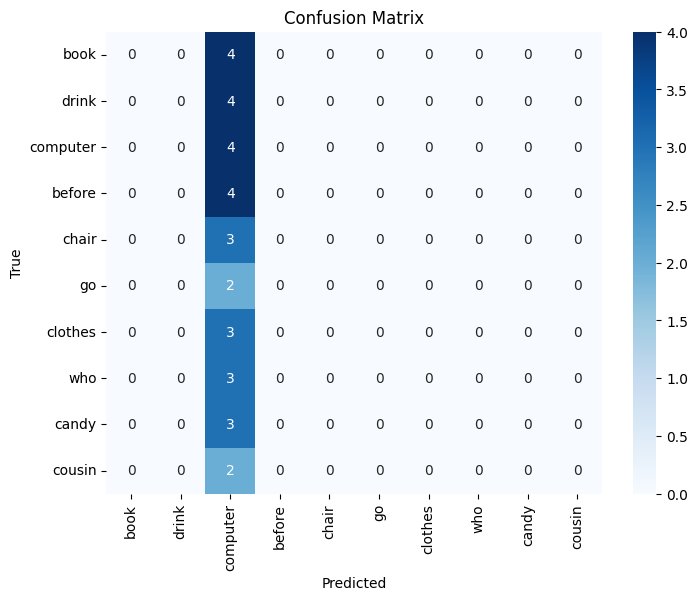

In [52]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=actions, yticklabels=actions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [113]:
# Calculate the accuracy score
accuracy = accuracy_score(test_labels, predicted_class_indices)
print("Test accuracy: {:.4f}".format(accuracy))

Test accuracy: 0.0938
